In [1]:
# Step 0: Install and Import Libraries
# No additional installs needed for basics, but for visualization:
!pip install seaborn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 1: Load the Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/healthcare-dataset-stroke-data.csv')

In [5]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (5110, 12)

First few rows:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Dataset info

In [7]:
# Step 2: Handling Missing Data
# Identify numerical columns for imputation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", numerical_cols)

# Impute missing values in 'bmi' with median
imputer = SimpleImputer(strategy='median')
df['bmi'] = imputer.fit_transform(df[['bmi']])

# Verify no missing values left
print("\nMissing values after imputation:")
print(df.isnull().sum())

Numerical columns: ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

Missing values after imputation:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [8]:
# Step 3: Encoding Categorical Variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
print("Categorical columns:", categorical_cols)

# Handle 'Other' in gender if present (rare, but encode)
# OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep numerical columns as is
)

# Apply encoding (we'll fit on full data for simplicity; in practice, fit on train)
encoded_data = preprocessor.fit_transform(df)
encoded_cols = preprocessor.get_feature_names_out()

df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols)
print("\nEncoded dataset shape:", df_encoded.shape)
print("\nFirst few rows of encoded data:")
print(df_encoded.head())

# Note: 'id' and 'stroke' are passthrough. Drop 'id' later as it's not a feature.
df_processed = df_encoded.drop(columns=['remainder__id'])  # Remove id
print("\nProcessed shape after dropping id:", df_processed.shape)

Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Encoded dataset shape: (5110, 18)

First few rows of encoded data:
   cat__gender_Male  cat__gender_Other  cat__ever_married_Yes  \
0               1.0                0.0                    1.0   
1               0.0                0.0                    1.0   
2               1.0                0.0                    1.0   
3               0.0                0.0                    1.0   
4               0.0                0.0                    1.0   

   cat__work_type_Never_worked  cat__work_type_Private  \
0                          0.0                     1.0   
1                          0.0                     0.0   
2                          0.0                     1.0   
3                          0.0                     1.0   
4                          0.0                     0.0   

   cat__work_type_Self-employed  cat__work_type_children  \
0                           0.0    

Numerical features for outlier detection: ['remainder__age', 'remainder__avg_glucose_level', 'remainder__bmi']


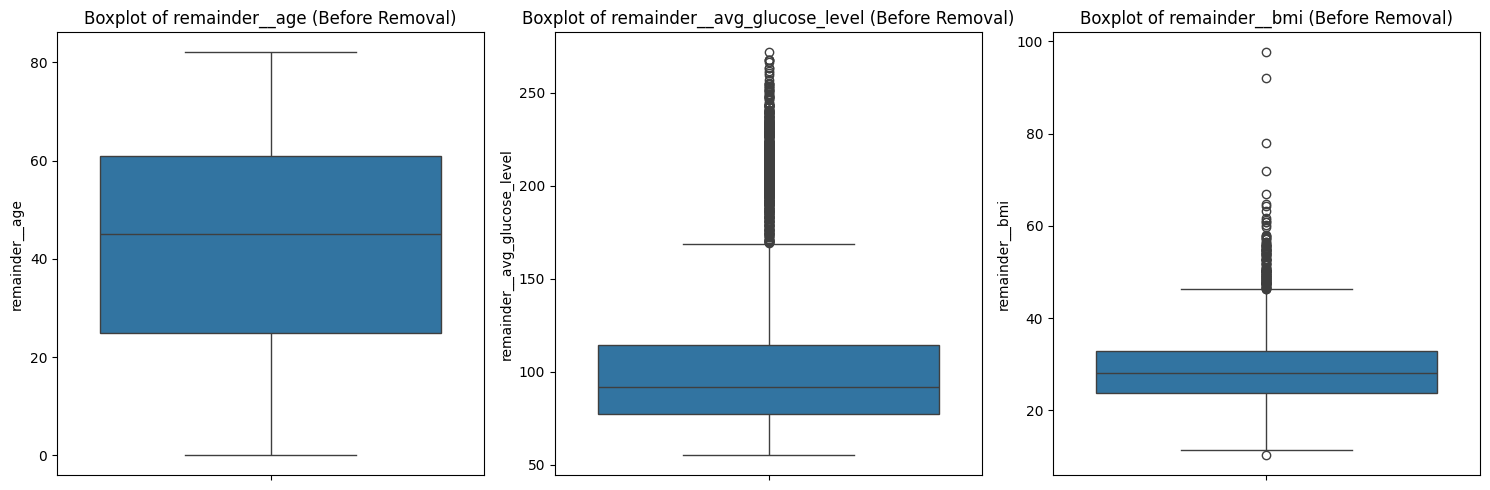


Shape after outlier removal: (4383, 17)
Removed 727 rows (14.23% of data)


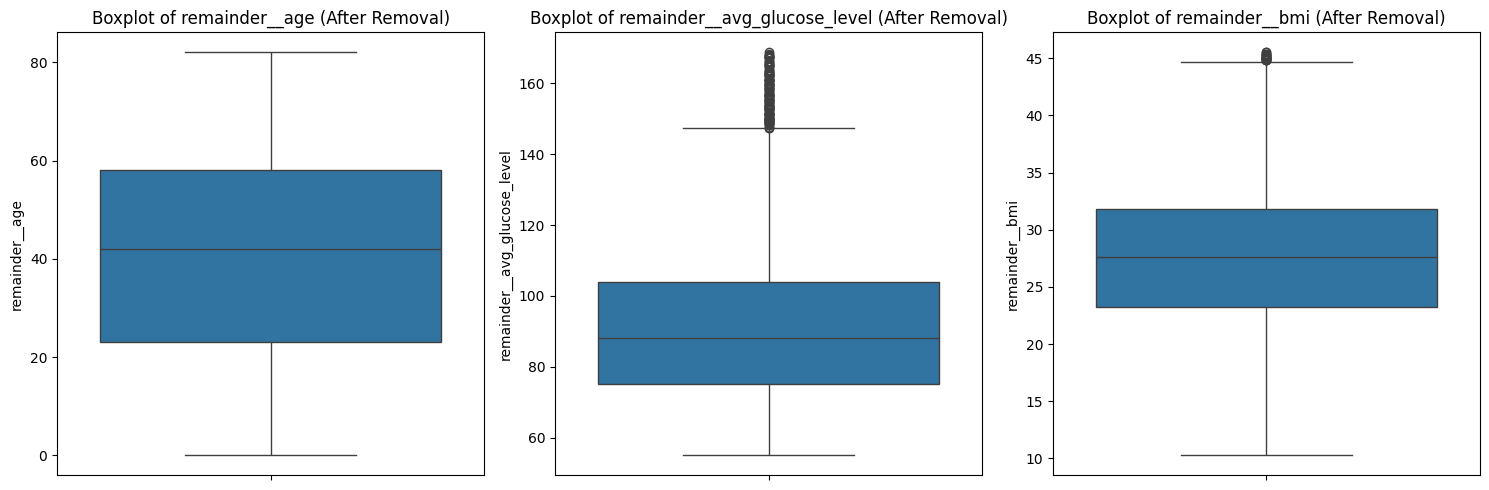

In [9]:
# Step 4: Outlier Removal
numerical_features = ['remainder__age', 'remainder__avg_glucose_level', 'remainder__bmi']
print("Numerical features for outlier detection:", numerical_features)

# Function to remove outliers using IQR
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Visualize before removal (optional)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df_processed, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} (Before Removal)')
plt.tight_layout()
plt.show()

# Remove outliers
df_no_outliers = remove_outliers(df_processed, numerical_features)
print("\nShape after outlier removal:", df_no_outliers.shape)
print(f"Removed {df_processed.shape[0] - df_no_outliers.shape[0]} rows ({((df_processed.shape[0] - df_no_outliers.shape[0]) / df_processed.shape[0] * 100):.2f}% of data)")

# Visualize after (optional)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numerical_features):
    sns.boxplot(data=df_no_outliers, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} (After Removal)')
plt.tight_layout()
plt.show()

In [12]:
# Step 5: Normalization / Scaling
# Numerical columns (after encoding, they are prefixed)
numerical_features_scaled = numerical_features  # Already identified

# ColumnTransformer for scaling only numerical
scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_scaled)
    ],
    remainder='passthrough'  # Keep categorical encoded and target
)

# Apply scaling
scaled_data = scaler.fit_transform(df_no_outliers)
scaled_cols = scaler.get_feature_names_out()
df_scaled = pd.DataFrame(scaled_data, columns=scaled_cols)

print("\nScaled dataset shape:", df_scaled.shape)
print("\nFirst few rows of scaled data:")
print(df_scaled.head())




Scaled dataset shape: (4383, 17)

First few rows of scaled data:
   num__remainder__age  num__remainder__avg_glucose_level  \
0             1.733246                           0.637398   
1             1.467317                          -0.943755   
2             1.245710                           0.128587   
3             0.802495                          -0.676332   
4             1.644603                          -1.452125   

   num__remainder__bmi  remainder__cat__gender_Male  \
0             0.729592                          1.0   
1            -0.052882                          1.0   
2            -0.758642                          0.0   
3             0.054517                          0.0   
4            -0.543846                          0.0   

   remainder__cat__gender_Other  remainder__cat__ever_married_Yes  \
0                           0.0                               1.0   
1                           0.0                               1.0   
2                           0


Columns in df_scaled: ['num__remainder__age', 'num__remainder__avg_glucose_level', 'num__remainder__bmi', 'remainder__cat__gender_Male', 'remainder__cat__gender_Other', 'remainder__cat__ever_married_Yes', 'remainder__cat__work_type_Never_worked', 'remainder__cat__work_type_Private', 'remainder__cat__work_type_Self-employed', 'remainder__cat__work_type_children', 'remainder__cat__Residence_type_Urban', 'remainder__cat__smoking_status_formerly smoked', 'remainder__cat__smoking_status_never smoked', 'remainder__cat__smoking_status_smokes', 'remainder__remainder__hypertension', 'remainder__remainder__heart_disease', 'remainder__remainder__stroke']

Identified target column: remainder__remainder__stroke

Features shape before selection: (4383, 16)
Target distribution:
remainder__remainder__stroke
0.0    4219
1.0     164
Name: count, dtype: int64

Selected 10 features: ['num__remainder__age', 'num__remainder__bmi', 'remainder__cat__ever_married_Yes', 'remainder__cat__work_type_Never_worked'

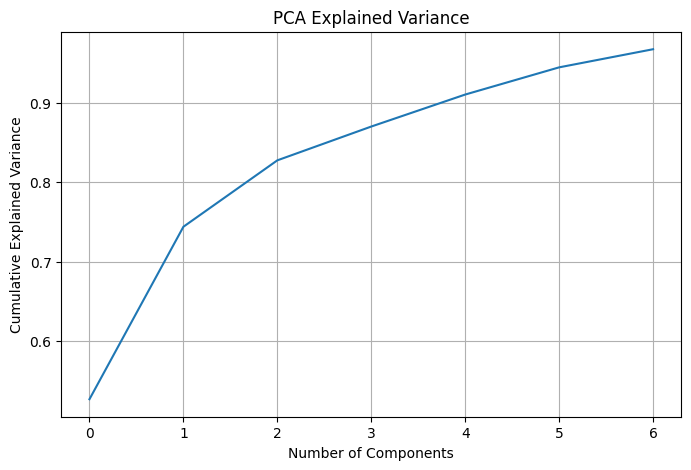


Train shape: (3506, 7), Test shape: (877, 7)


In [15]:
# Step 6: Feature Engineering
# Import necessary libraries (should already be imported from earlier steps)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Check columns in df_scaled to debug
print("\nColumns in df_scaled:", df_scaled.columns.tolist())

# Identify the target column
# Replace 'remainder__stroke' with the actual column name if different
target_column = None
for col in df_scaled.columns:
    if 'stroke' in col.lower():
        target_column = col
        break

if target_column is None:
    raise ValueError("Target column containing 'stroke' not found in df_scaled. Please check preprocessing steps.")

print(f"\nIdentified target column: {target_column}")

# Separate features and target
X = df_scaled.drop(columns=[target_column])
y = df_scaled[target_column]

print("\nFeatures shape before selection:", X.shape)
print("Target distribution:")
print(y.value_counts())

# 6a: Feature Selection - Select top 10 features (adjust k as needed)
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print(f"\nSelected {X_selected.shape[1]} features: {selected_features}")

# Create DataFrame with selected features
df_selected = pd.DataFrame(X_selected, columns=selected_features)
df_selected['stroke'] = y.values  # Add target back

# 6b: Dimension Reduction - PCA
# Apply PCA to selected features, retain 95% variance
pca = PCA(n_components=0.95)  # or fixed, e.g., n_components=5
X_pca = pca.fit_transform(df_selected.drop(columns=['stroke']))
print(f"\nPCA components: {X_pca.shape[1]} (explained variance ratio: {pca.explained_variance_ratio_.sum():.4f})")

# Create final DataFrame
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca['stroke'] = y.values

print("\nFinal PCA dataset shape:", df_pca.shape)
print("\nFirst few rows:")
print(df_pca.head())

# Visualize PCA variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Split for training
X_final, y_final = df_pca.drop(columns=['stroke']), df_pca['stroke']
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")